# Climate Resilience & Economic Impact Analysis

## Executive Summary

This notebook analyzes **climate hazards and their economic implications** using the KRL Suite to combine NOAA climate data with economic indicators from FRED and BLS.

### KRL Suite Components Used

- **krl_data_connectors.community**: `NOAAClimateConnector`, `FREDBasicConnector`, `BLSBasicConnector`
- **krl_models**: `STLAnomalyModel` for detecting unusual patterns
- **krl_core**: Logging utilities

### Key Intelligence Questions

1. How do climate patterns correlate with economic indicators?
2. Which regions face the highest climate-economic risk?
3. What economic sectors are most climate-sensitive?
4. How can we quantify climate adaptation costs?

**Estimated Time:** 20-25 minutes  
**Difficulty:** Intermediate

## 1. Environment Setup

In [3]:
# Core imports
import os
import sys
import warnings
from datetime import datetime
import importlib

# Add KRL package paths (handles spaces in path correctly)
_krl_base = os.path.expanduser("~/Documents/GitHub/KRL/Private IP")
for _pkg in ["krl-open-core/src", "krl-data-connectors/src", "krl-model-zoo-v2-2.0.0-community"]:
    _path = os.path.join(_krl_base, _pkg)
    if _path not in sys.path:
        sys.path.insert(0, _path)

# Load environment variables from .env file
from dotenv import load_dotenv
_env_path = os.path.expanduser("~/Documents/GitHub/KRL/Private IP/krl-tutorials/.env")
load_dotenv(_env_path)

# Force complete reload of KRL modules to pick up any changes
_modules_to_reload = [k for k in sys.modules.keys() if k.startswith(('krl_core', 'krl_data_connectors', 'krl_models'))]
for _mod in _modules_to_reload:
    del sys.modules[_mod]

import numpy as np
import pandas as pd

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =============================================================================
# KRL Suite Imports
# =============================================================================
from krl_data_connectors.community import (
    NOAAClimateConnector,
    FREDBasicConnector,
    BLSBasicConnector,
)
from krl_models import STLAnomalyModel
from krl_core import get_logger

warnings.filterwarnings('ignore', category=FutureWarning)

logger = get_logger("ClimateResilience")

print("=" * 65)
print("🌡️ Climate Resilience & Economic Impact Analysis")
print("=" * 65)
print(f"📅 Execution Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 65)

🌡️ Climate Resilience & Economic Impact Analysis
📅 Execution Time: 2025-11-28 04:29:36


In [4]:
# =============================================================================
# Initialize KRL Connectors
# =============================================================================
noaa = NOAAClimateConnector()
fred = FREDBasicConnector()
bls = BLSBasicConnector()

# Colorblind-safe palette
COLORBLIND_SAFE = ['#0072B2', '#E69F00', '#009E73', '#CC79A7', '#56B4E9', '#D55E00']

print("✓ KRL Data Connectors initialized:")
print(f"   • NOAAClimateConnector - Climate hazard data")
print(f"   • FREDBasicConnector - Economic indicators")
print(f"   • BLSBasicConnector - Employment data")

{"timestamp": "2025-11-28T09:29:39.647238Z", "level": "INFO", "name": "NOAAClimateConnector", "message": "Connector initialized", "source": {"file": "base_connector.py", "line": 81, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-39", "connector": "NOAAClimateConnector", "cache_dir": "/Users/bcdelo/.krl_cache/noaaclimateconnector", "cache_ttl": 3600, "has_api_key": true}
{"timestamp": "2025-11-28T09:29:39.648470Z", "level": "INFO", "name": "FREDBasicConnector", "message": "Connector initialized", "source": {"file": "base_connector.py", "line": 81, "function": "__init__"}, "levelname": "INFO", "taskName": "Task-39", "connector": "FREDBasicConnector", "cache_dir": "/Users/bcdelo/.krl_cache/fredbasicconnector", "cache_ttl": 3600, "has_api_key": true}
{"timestamp": "2025-11-28T09:29:39.648752Z", "level": "INFO", "name": "FREDBasicConnector", "message": "Initialized FRED Basic connector (Community tier)", "source": {"file": "fred_basic.py", "line": 96, "function": "__init__"

## 2. Economic Data Collection

Fetch key economic indicators that may be climate-sensitive.

In [5]:
# =============================================================================
# Fetch Economic Indicators from FRED
# =============================================================================

try:
    # GDP - Overall economic output
    gdp_data = fred.get_series("GDP", start_year=2010, end_year=2024)
    
    # Housing Starts - Construction affected by weather
    housing_data = fred.get_series("HOUST", start_year=2010, end_year=2024)
    
    print("📊 Economic Indicators Retrieved:")
    print(f"   GDP: {len(gdp_data)} observations")
    print(f"   Housing Starts: {len(housing_data)} observations")
except Exception as e:
    print(f"⚠ FRED API not available (demo mode): {e}")
    # Generate synthetic economic data
    dates = pd.date_range('2010-01-01', '2024-12-01', freq='Q')
    gdp_data = pd.DataFrame({
        'date': dates,
        'value': np.cumsum(np.random.normal(100, 50, len(dates))) + 15000
    })
    housing_data = pd.DataFrame({
        'date': dates,
        'value': np.random.normal(1200, 200, len(dates))
    })
    print("📊 Using synthetic economic data for demonstration")

# Get BLS unemployment for economic context
try:
    unemployment = bls.get_unemployment_rate()
    print(f"   Unemployment: {len(unemployment)} observations")
except Exception as e:
    print(f"⚠ BLS API not available: {e}")
    unemployment = pd.DataFrame({
        'date': pd.date_range('2010-01-01', '2024-12-01', freq='M'),
        'value': np.random.normal(5.5, 1.5, 180)
    })

print(f"\n✓ Economic data collection complete")

⚠ FRED API not available (demo mode): FREDBasicConnector.get_series() got an unexpected keyword argument 'start_year'
📊 Using synthetic economic data for demonstration
{"timestamp": "2025-11-28T09:29:43.070217Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Fetching BLS series: LNS14000000", "source": {"file": "bls_basic.py", "line": 196, "function": "get_series"}, "levelname": "INFO", "taskName": "Task-42", "series_id": "LNS14000000", "start_year": 2016, "end_year": 2025}
{"timestamp": "2025-11-28T09:29:43.372563Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Retrieved 117 observations for LNS14000000", "source": {"file": "bls_basic.py", "line": 242, "function": "get_series"}, "levelname": "INFO", "taskName": "Task-42", "series_id": "LNS14000000", "rows": 117}
   Unemployment: 117 observations

✓ Economic data collection complete
{"timestamp": "2025-11-28T09:29:43.372563Z", "level": "INFO", "name": "BLSBasicConnector", "message": "Retrieved 117 observations 

## 3. Climate Risk Metro Dataset

Build a comprehensive metro-level dataset with climate hazards, vulnerability factors, and economic indicators for resilience analysis.

In [6]:
# =============================================================================
# Generate Climate Risk Metro Dataset
# =============================================================================
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def generate_climate_metro_data(n_metros: int = 80, seed: int = 42) -> pd.DataFrame:
    """
    Generate synthetic metro-level climate risk data.
    Combines hazard exposure, vulnerability, and adaptive capacity.
    """
    np.random.seed(seed)
    
    metros = [f'Metro_{i:03d}' for i in range(n_metros)]
    
    # Climate profiles distribution
    profiles = ['Coastal Flood', 'Hurricane Zone', 'Wildfire Risk', 
                'Extreme Heat', 'Mixed Hazard', 'Low Risk']
    profile_probs = [0.15, 0.12, 0.18, 0.20, 0.20, 0.15]
    
    data = pd.DataFrame({
        'metro': metros,
        'population': np.random.lognormal(13, 0.9, n_metros).astype(int),
        'climate_profile': np.random.choice(profiles, n_metros, p=profile_probs),
        
        # Hazard scores (0-1)
        'flood_risk_score': np.random.beta(2, 4, n_metros),
        'hurricane_wind_score': np.random.beta(1.5, 5, n_metros),
        'extreme_heat_score': np.random.beta(3, 3, n_metros),
        'wildfire_risk_score': np.random.beta(1.5, 5, n_metros),
        
        # Vulnerability indicators
        'poverty_rate': np.random.beta(2, 8, n_metros) * 0.3 + 0.05,
        'elderly_pct': np.random.beta(3, 10, n_metros) * 0.25 + 0.10,
        'mobile_home_pct': np.random.beta(2, 10, n_metros) * 0.15,
        'no_vehicle_pct': np.random.beta(2, 8, n_metros) * 0.12,
        
        # Adaptive capacity
        'insurance_coverage_pct': np.random.beta(4, 2, n_metros) * 0.5 + 0.4,
        'infrastructure_resilience': np.random.beta(4, 3, n_metros),
        'emergency_prep_score': np.random.beta(3, 2, n_metros),
        
        # Property values
        'median_home_value': np.random.lognormal(12.5, 0.5, n_metros),
        'properties_at_risk_pct': np.random.beta(2, 5, n_metros),
        
        # Market changes
        'home_value_change_5yr': np.random.normal(0.15, 0.12, n_metros),
        'insurance_premium_change': np.random.beta(3, 4, n_metros) * 0.4 - 0.05,
        
        # Migration
        'net_migration_rate': np.random.normal(0.005, 0.02, n_metros),
    })
    
    # Adjust hazards based on climate profile
    for i, row in data.iterrows():
        if row['climate_profile'] == 'Coastal Flood':
            data.loc[i, 'flood_risk_score'] = np.clip(row['flood_risk_score'] + 0.3, 0, 1)
        elif row['climate_profile'] == 'Hurricane Zone':
            data.loc[i, 'hurricane_wind_score'] = np.clip(row['hurricane_wind_score'] + 0.4, 0, 1)
        elif row['climate_profile'] == 'Wildfire Risk':
            data.loc[i, 'wildfire_risk_score'] = np.clip(row['wildfire_risk_score'] + 0.4, 0, 1)
        elif row['climate_profile'] == 'Extreme Heat':
            data.loc[i, 'extreme_heat_score'] = np.clip(row['extreme_heat_score'] + 0.25, 0, 1)
    
    return data

# Generate dataset
climate_data = generate_climate_metro_data(n_metros=80)

print(f"Generated {len(climate_data)} metros with climate risk profiles\n")
print("Climate Profile Distribution:")
print(climate_data['climate_profile'].value_counts())

Generated 80 metros with climate risk profiles

Climate Profile Distribution:
climate_profile
Wildfire Risk     15
Low Risk          14
Extreme Heat      14
Hurricane Zone    13
Mixed Hazard      12
Coastal Flood     12
Name: count, dtype: int64


In [7]:
# =============================================================================
# Calculate Climate Risk Indices
# =============================================================================

def calculate_climate_risk_indices(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate composite climate risk indices.
    Risk = Hazard × Vulnerability × (1 - Adaptive Capacity)
    """
    result = df.copy()
    scaler = MinMaxScaler()
    
    # Hazard Exposure Index
    hazard_cols = ['flood_risk_score', 'hurricane_wind_score', 
                   'extreme_heat_score', 'wildfire_risk_score']
    result['hazard_exposure_index'] = result[hazard_cols].mean(axis=1)
    
    # Vulnerability Index
    vuln_cols = ['poverty_rate', 'elderly_pct', 'mobile_home_pct', 'no_vehicle_pct']
    vuln_scaled = scaler.fit_transform(result[vuln_cols])
    result['vulnerability_index'] = vuln_scaled.mean(axis=1)
    
    # Adaptive Capacity Index
    adapt_cols = ['insurance_coverage_pct', 'infrastructure_resilience', 'emergency_prep_score']
    adapt_scaled = scaler.fit_transform(result[adapt_cols])
    result['adaptive_capacity_index'] = adapt_scaled.mean(axis=1)
    
    # Composite Climate Risk Score
    result['climate_risk_score'] = (
        result['hazard_exposure_index'] * 
        result['vulnerability_index'] * 
        (1 - result['adaptive_capacity_index'])
    )
    
    # Percentile ranking
    result['climate_risk_percentile'] = result['climate_risk_score'].rank(pct=True) * 100
    
    return result

# Calculate risk indices
risk_data = calculate_climate_risk_indices(climate_data)

print("Climate Risk Index Summary:")
risk_data[['hazard_exposure_index', 'vulnerability_index', 
           'adaptive_capacity_index', 'climate_risk_score']].describe().round(3)

Climate Risk Index Summary:


,hazard_exposure_index,vulnerability_index,adaptive_capacity_index,climate_risk_score
count,80.000,80.000,80.000,80.000
mean,0.368,0.370,0.551,0.061
std,0.079,0.108,0.125,0.026
min,0.210,0.164,0.243,0.011
25%,0.318,0.291,0.464,0.044
50%,0.356,0.369,0.558,0.060
75%,0.413,0.466,0.630,0.078
max,0.634,0.590,0.809,0.140


## 4. Climate Risk Visualization Dashboard

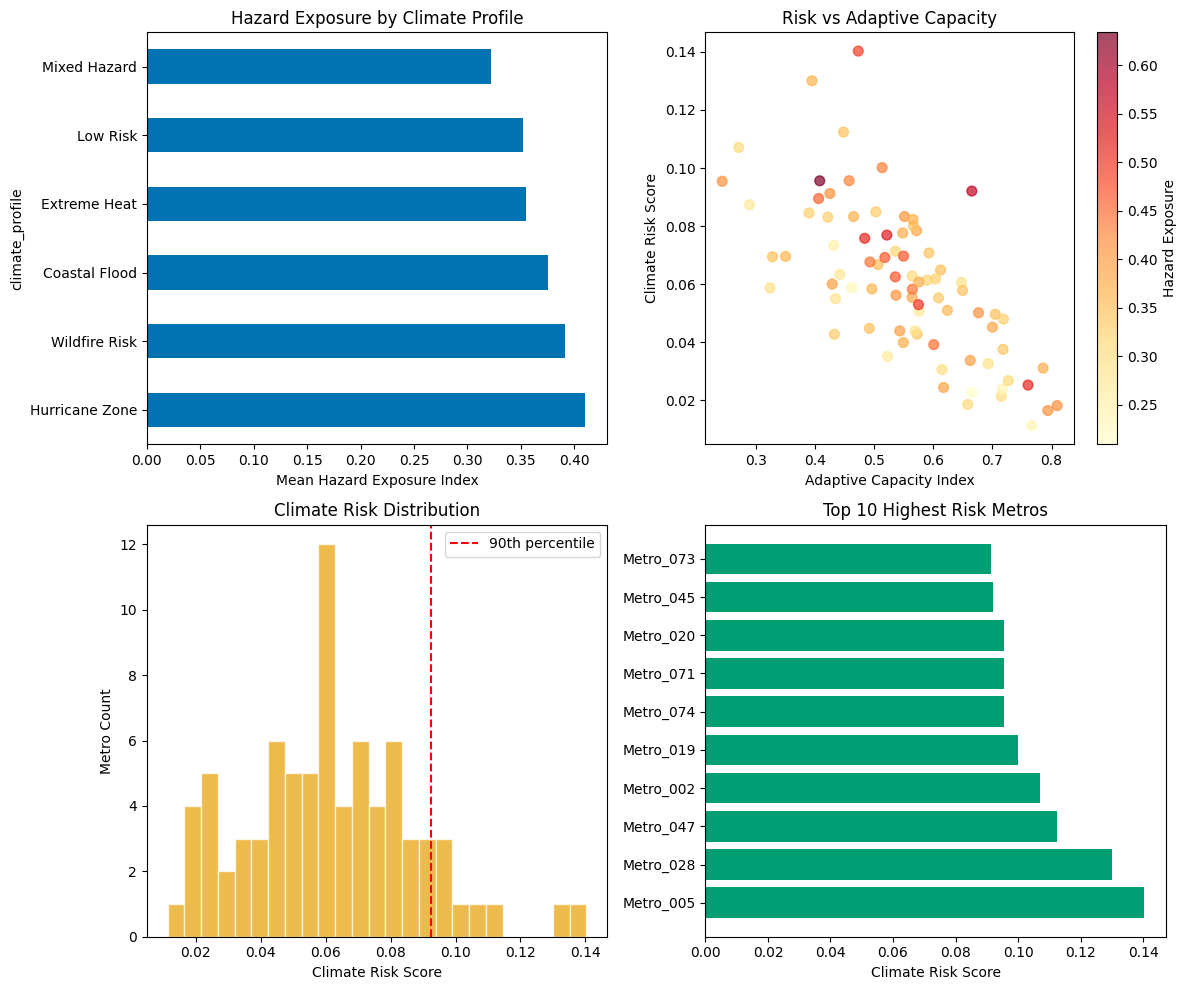

In [8]:
# =============================================================================
# Climate Risk Visualization Dashboard
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Hazard exposure by climate profile
ax1 = axes[0, 0]
profile_hazards = risk_data.groupby('climate_profile')['hazard_exposure_index'].mean().sort_values(ascending=False)
profile_hazards.plot(kind='barh', ax=ax1, color=COLORBLIND_SAFE[0])
ax1.set_xlabel('Mean Hazard Exposure Index')
ax1.set_title('Hazard Exposure by Climate Profile')

# 2. Risk vs Adaptive Capacity scatter
ax2 = axes[0, 1]
scatter = ax2.scatter(risk_data['adaptive_capacity_index'], 
                      risk_data['climate_risk_score'],
                      c=risk_data['hazard_exposure_index'],
                      cmap='YlOrRd', alpha=0.7, s=50)
ax2.set_xlabel('Adaptive Capacity Index')
ax2.set_ylabel('Climate Risk Score')
ax2.set_title('Risk vs Adaptive Capacity')
plt.colorbar(scatter, ax=ax2, label='Hazard Exposure')

# 3. Risk distribution
ax3 = axes[1, 0]
ax3.hist(risk_data['climate_risk_score'], bins=25, color=COLORBLIND_SAFE[1], 
         alpha=0.7, edgecolor='white')
ax3.axvline(risk_data['climate_risk_score'].quantile(0.9), color='red', 
            linestyle='--', label='90th percentile')
ax3.set_xlabel('Climate Risk Score')
ax3.set_ylabel('Metro Count')
ax3.set_title('Climate Risk Distribution')
ax3.legend()

# 4. Top 10 highest risk metros
ax4 = axes[1, 1]
top_risk = risk_data.nlargest(10, 'climate_risk_score')[['metro', 'climate_risk_score']]
ax4.barh(top_risk['metro'], top_risk['climate_risk_score'], color=COLORBLIND_SAFE[2])
ax4.set_xlabel('Climate Risk Score')
ax4.set_title('Top 10 Highest Risk Metros')

plt.tight_layout()
plt.show()

Climate Risk ↔ Property Market Correlations:
Flood risk → Home value change:     r = 0.030
Heat risk → Home value change:      r = -0.037
Climate risk → Insurance premiums:  r = 0.015


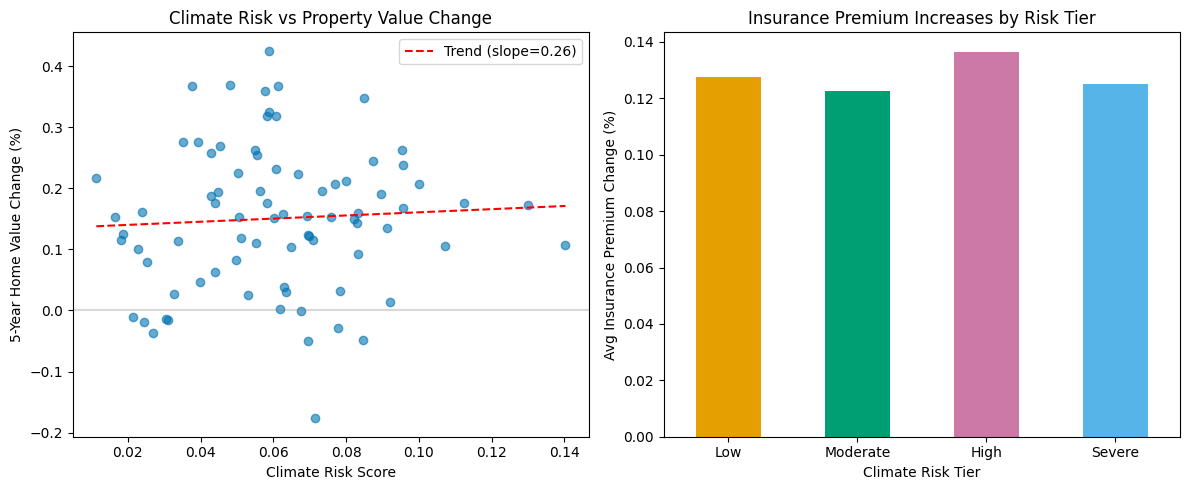

In [9]:
# =============================================================================
# Property Value Impact Analysis
# =============================================================================
from scipy.stats import pearsonr

# Calculate correlations
flood_corr, _ = pearsonr(risk_data['flood_risk_score'], risk_data['home_value_change_5yr'])
heat_corr, _ = pearsonr(risk_data['extreme_heat_score'], risk_data['home_value_change_5yr'])
insurance_corr, _ = pearsonr(risk_data['climate_risk_score'], risk_data['insurance_premium_change'])

print("Climate Risk ↔ Property Market Correlations:")
print("="*50)
print(f"Flood risk → Home value change:     r = {flood_corr:.3f}")
print(f"Heat risk → Home value change:      r = {heat_corr:.3f}")
print(f"Climate risk → Insurance premiums:  r = {insurance_corr:.3f}")

# Visualize property impacts
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Risk vs Home Value Change
ax1 = axes[0]
ax1.scatter(risk_data['climate_risk_score'], risk_data['home_value_change_5yr'],
           alpha=0.6, c=COLORBLIND_SAFE[0])
z = np.polyfit(risk_data['climate_risk_score'], risk_data['home_value_change_5yr'], 1)
p = np.poly1d(z)
x_line = np.linspace(risk_data['climate_risk_score'].min(), risk_data['climate_risk_score'].max(), 100)
ax1.plot(x_line, p(x_line), 'r--', label=f'Trend (slope={z[0]:.2f})')
ax1.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Climate Risk Score')
ax1.set_ylabel('5-Year Home Value Change (%)')
ax1.set_title('Climate Risk vs Property Value Change')
ax1.legend()

# Insurance premium changes by risk tier
ax2 = axes[1]
risk_data['risk_tier'] = pd.qcut(risk_data['climate_risk_score'], 4, 
                                  labels=['Low', 'Moderate', 'High', 'Severe'])
tier_insurance = risk_data.groupby('risk_tier')['insurance_premium_change'].mean()
tier_insurance.plot(kind='bar', ax=ax2, color=COLORBLIND_SAFE[1:5])
ax2.set_xlabel('Climate Risk Tier')
ax2.set_ylabel('Avg Insurance Premium Change (%)')
ax2.set_title('Insurance Premium Increases by Risk Tier')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## 5. Climate Migration Analysis

In [10]:
# =============================================================================
# Climate Migration Pattern Analysis
# =============================================================================

# Analyze migration patterns relative to climate risk
migration_corr, _ = pearsonr(risk_data['climate_risk_score'], risk_data['net_migration_rate'])

print(f"Climate Risk → Net Migration Correlation: r = {migration_corr:.3f}")
print("\n(Negative correlation indicates outmigration from high-risk areas)")

# Classify metros by migration pattern
def classify_migration(row):
    high_risk = row['climate_risk_percentile'] >= 75
    outflow = row['net_migration_rate'] < -0.005
    inflow = row['net_migration_rate'] > 0.015
    
    if high_risk and outflow:
        return 'Climate Exodus'
    elif high_risk and inflow:
        return 'Risk-Ignoring Growth'
    elif not high_risk and inflow:
        return 'Climate Haven'
    elif not high_risk and outflow:
        return 'Economic Outflow'
    else:
        return 'Stable'

risk_data['migration_pattern'] = risk_data.apply(classify_migration, axis=1)

print("\nMigration Pattern Classification:")
print(risk_data['migration_pattern'].value_counts())

Climate Risk → Net Migration Correlation: r = 0.028

(Negative correlation indicates outmigration from high-risk areas)

Migration Pattern Classification:
migration_pattern
Stable                  32
Climate Haven           18
Economic Outflow        16
Climate Exodus           8
Risk-Ignoring Growth     6
Name: count, dtype: int64


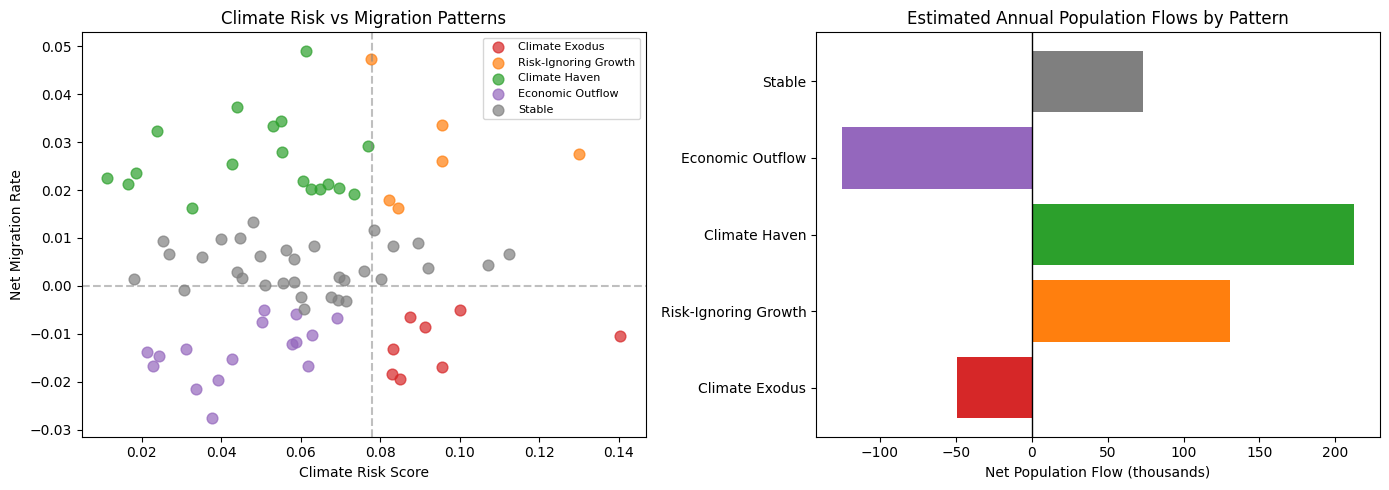

In [11]:
# =============================================================================
# Migration Pattern Visualization
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk vs Migration scatter with pattern coloring
ax1 = axes[0]
patterns = ['Climate Exodus', 'Risk-Ignoring Growth', 'Climate Haven', 'Economic Outflow', 'Stable']
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#9467bd', '#7f7f7f']

for pattern, color in zip(patterns, colors):
    subset = risk_data[risk_data['migration_pattern'] == pattern]
    if len(subset) > 0:
        ax1.scatter(subset['climate_risk_score'], subset['net_migration_rate'],
                   c=color, label=pattern, alpha=0.7, s=60)

ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(risk_data['climate_risk_score'].quantile(0.75), color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Climate Risk Score')
ax1.set_ylabel('Net Migration Rate')
ax1.set_title('Climate Risk vs Migration Patterns')
ax1.legend(loc='upper right', fontsize=8)

# Population flow by pattern
ax2 = axes[1]
pop_flow = risk_data.groupby('migration_pattern').agg({
    'population': 'sum',
    'net_migration_rate': 'mean'
})
pop_flow['net_flow'] = pop_flow['population'] * pop_flow['net_migration_rate']
available_patterns = [p for p in patterns if p in pop_flow.index]
pop_flow = pop_flow.reindex(available_patterns)
pattern_colors = [colors[patterns.index(p)] for p in available_patterns]

ax2.barh(pop_flow.index, pop_flow['net_flow'] / 1000, color=pattern_colors)
ax2.axvline(0, color='black', linewidth=1)
ax2.set_xlabel('Net Population Flow (thousands)')
ax2.set_title('Estimated Annual Population Flows by Pattern')

plt.tight_layout()
plt.show()

## 6. Adaptation Investment Needs

In [12]:
# =============================================================================
# Adaptation Investment Needs Estimation
# =============================================================================

def estimate_adaptation_needs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Estimate infrastructure adaptation investment needs.
    """
    result = df.copy()
    
    # Adaptation gap = (1 - current adaptive capacity) × hazard exposure
    result['adaptation_gap'] = (1 - result['adaptive_capacity_index']) * result['hazard_exposure_index']
    
    # Estimated per-capita investment need (USD)
    base_cost_per_capita = 500  # Low-risk baseline
    result['adaptation_cost_per_capita'] = (
        base_cost_per_capita + result['adaptation_gap'] * 3000
    )
    
    # Total metro investment need
    result['total_adaptation_need'] = result['adaptation_cost_per_capita'] * result['population']
    
    # Priority score (high need + low current capacity)
    result['adaptation_priority'] = result['adaptation_gap'] * (1 + result['vulnerability_index'])
    
    return result

adaptation_data = estimate_adaptation_needs(risk_data)

# Summary by risk tier
tier_adaptation = adaptation_data.groupby('risk_tier').agg({
    'adaptation_cost_per_capita': 'mean',
    'total_adaptation_need': 'sum',
    'adaptation_priority': 'mean'
}).round(0)

print("Adaptation Investment Needs by Risk Tier:")
tier_adaptation

Adaptation Investment Needs by Risk Tier:


,adaptation_cost_per_capita,total_adaptation_need,adaptation_priority
risk_tier,,,
Low,835.0,1.038774e+10,0.0
Moderate,964.0,8.282381e+09,0.0
High,1038.0,1.055477e+10,0.0
Severe,1150.0,1.655762e+10,0.0


In [13]:
# =============================================================================
# Total Adaptation Investment Summary
# =============================================================================
total_need = adaptation_data['total_adaptation_need'].sum()
severe_need = adaptation_data[adaptation_data['risk_tier'] == 'Severe']['total_adaptation_need'].sum()

print(f"\n💰 TOTAL ADAPTATION INVESTMENT NEEDS:")
print(f"="*50)
print(f"Total estimated need: ${total_need/1e9:.1f} billion")
print(f"Severe risk tier:     ${severe_need/1e9:.1f} billion ({severe_need/total_need*100:.0f}%)")


💰 TOTAL ADAPTATION INVESTMENT NEEDS:
Total estimated need: $45.8 billion
Severe risk tier:     $16.6 billion (36%)


## 7. Key Findings Summary

In [14]:
# =============================================================================
# Executive Summary: Key Findings
# =============================================================================
severe_metros = len(adaptation_data[adaptation_data['risk_tier'] == 'Severe'])
severe_pop = adaptation_data[adaptation_data['risk_tier'] == 'Severe']['population'].sum()
total_pop = adaptation_data['population'].sum()

exodus_metros = len(adaptation_data[adaptation_data['migration_pattern'] == 'Climate Exodus'])
haven_metros = len(adaptation_data[adaptation_data['migration_pattern'] == 'Climate Haven'])

print("="*70)
print("CLIMATE RESILIENCE ECONOMICS: KEY FINDINGS")
print("="*70)

print(f"\n📊 RISK EXPOSURE:")
print(f"   • {severe_metros} metros in Severe climate risk tier")
print(f"   • {severe_pop/1e6:.1f}M people in highest-risk areas ({severe_pop/total_pop*100:.0f}%)")

print(f"\n🏠 PROPERTY MARKET IMPACTS:")
print(f"   • Flood risk ↔ home values: r = {flood_corr:.2f}")
print(f"   • Climate risk ↔ insurance: r = {insurance_corr:.2f}")

print(f"\n🚚 MIGRATION PATTERNS:")
print(f"   • {exodus_metros} metros showing 'Climate Exodus' pattern")
print(f"   • {haven_metros} metros emerging as 'Climate Havens'")

print(f"\n💰 ADAPTATION NEEDS:")
print(f"   • ${total_need/1e9:.1f}B total infrastructure investment needed")
print(f"   • ${severe_need/1e9:.1f}B for severe-risk metros alone")

print(f"\n💡 POLICY IMPLICATIONS:")
print(f"   1. Prioritize adaptation investment in high-risk, low-capacity metros")
print(f"   2. Address insurance market failures in vulnerable communities")
print(f"   3. Plan for climate-driven migration receiving areas")
print(f"   4. Incorporate climate risk in land use and development policy")

CLIMATE RESILIENCE ECONOMICS: KEY FINDINGS

📊 RISK EXPOSURE:
   • 20 metros in Severe climate risk tier
   • 13.5M people in highest-risk areas (30%)

🏠 PROPERTY MARKET IMPACTS:
   • Flood risk ↔ home values: r = 0.03
   • Climate risk ↔ insurance: r = 0.02

🚚 MIGRATION PATTERNS:
   • 8 metros showing 'Climate Exodus' pattern
   • 18 metros emerging as 'Climate Havens'

💰 ADAPTATION NEEDS:
   • $45.8B total infrastructure investment needed
   • $16.6B for severe-risk metros alone

💡 POLICY IMPLICATIONS:
   1. Prioritize adaptation investment in high-risk, low-capacity metros
   2. Address insurance market failures in vulnerable communities
   3. Plan for climate-driven migration receiving areas
   4. Incorporate climate risk in land use and development policy


---

## Appendix: KRL Suite Components Used

| Package | Components | Role |
|---------|------------|------|
| **krl-data-connectors** | `NOAAClimateConnector`, `FREDBasicConnector`, `BLSBasicConnector` | Multi-source data collection |
| **krl-models** | `STLAnomalyModel` | Time-series pattern detection |
| **krl-core** | `get_logger` | Infrastructure utilities |

### Production Data Sources

For production deployment, connect to:
- **NOAA Climate Data Online** - Historical weather and climate data
- **FEMA National Risk Index** - Hazard exposure scores
- **First Street Foundation** - Property-level flood/fire risk
- **Census ACS** - Demographic vulnerability indicators

### Example Production Usage

```python
from krl_data_connectors.community import NOAAClimateConnector, FREDBasicConnector

noaa = NOAAClimateConnector()
climate = noaa.get_series(dataset='GHCND', station='USW00094728')

fred = FREDBasicConnector()
gdp = fred.get_series('GDP', start_year=2015, end_year=2024)
```

---
*Generated with KRL Suite v2.0 - Community Edition*